In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import json
import random
import matplotlib.pyplot as plt

# Create table sessions

In [2]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

# SQL statement to create the 'sessions' table
create_table_sql = """
CREATE TABLE sessions (
    session_id INT AUTO_INCREMENT PRIMARY KEY,
    player_id INT,
    starttime DATETIME,
    endtime DATETIME,
    FOREIGN KEY (player_id) REFERENCES players(PlayerID)
)
"""
cursor.execute(create_table_sql)

# Commit the transaction
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

# Generate sessions

In [15]:
# Define the number of rows you want for the DataFrame
num_rows = 2000

# Generate random player_ids (assuming you have a maximum of 100 players for simplicity)
player_ids = np.random.randint(1, 71, num_rows)

# Generate random start times between '2021-01-01' and '2022-12-31'
start_dates = pd.date_range('2021-01-01', '2022-12-31', freq='T').to_list()
random_start_times = np.random.choice(start_dates, num_rows)
random_start_times = [time + timedelta(minutes=np.random.randint(0, 60), seconds=np.random.randint(0, 60)) for time in random_start_times]

# Calculate random end times, ensuring that the session is no longer than 8 hours
random_time_deltas = [timedelta(hours=np.random.randint(0, 9), minutes=np.random.randint(0, 60), seconds=np.random.randint(0, 60)) for _ in range(num_rows)]
end_times = [start + delta for start, delta in zip(random_start_times, random_time_deltas)]

# Filter out those entries where end times have exceeded '2023-01-01'
filtered_indices = [index for index, time in enumerate(end_times) if time <= datetime(2023, 1, 1)]
player_ids = np.array(player_ids)[filtered_indices]
random_start_times = np.array(random_start_times)[filtered_indices]
end_times = np.array(end_times)[filtered_indices]

# Construct the DataFrame
sessions_df = pd.DataFrame({
    'player_id': player_ids,
    'starttime': random_start_times,
    'endtime': end_times
})


# Generate 50 anomalous start times
anomalous_start_times = np.random.choice(start_dates, 50)
anomalous_start_times = [time + timedelta(minutes=np.random.randint(0, 60), seconds=np.random.randint(0, 60)) for time in anomalous_start_times]

# Calculate anomalous end times, ensuring that the session is between 8 and 24 hours
anomalous_time_deltas = [timedelta(hours=np.random.randint(8, 25), minutes=np.random.randint(0, 60), seconds=np.random.randint(0, 60)) for _ in range(50)]
anomalous_end_times = [start + delta for start, delta in zip(anomalous_start_times, anomalous_time_deltas)]

# Generate player_ids for the anomalous entries
anomalous_player_ids = np.random.randint(1, 71, 50)

# Construct the DataFrame for anomalies
anomalies_df = pd.DataFrame({
    'player_id': anomalous_player_ids,
    'starttime': anomalous_start_times,
    'endtime': anomalous_end_times
})

# Concatenate the original sessions_df with the anomalies_df
sessions_df = pd.concat([sessions_df, anomalies_df], ignore_index=True)

In [20]:
sessions_df

,player_id,starttime,endtime
0,34,2021-08-03 00:29:28,2021-08-03 04:29:43
1,66,2021-09-06 06:36:24,2021-09-06 13:23:17
2,7,2022-01-21 08:10:26,2022-01-21 11:48:19
3,11,2021-11-07 00:29:15,2021-11-07 06:03:25
4,43,2021-02-28 03:54:18,2021-02-28 09:52:56
...,...,...,...
2045,38,2022-07-13 13:00:38,2022-07-14 10:51:36
2046,55,2022-05-29 11:29:36,2022-05-30 00:14:41
2047,24,2022-03-17 08:45:48,2022-03-18 09:06:58
2048,25,2022-04-06 02:11:21,2022-04-06 16:00:58


In [19]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

for index, row in sessions_df.iterrows():
    sql = """
    INSERT INTO sessions (player_id, starttime, endtime)
    VALUES (%s, %s, %s)
    """
    
    values = (row['player_id'], row['starttime'], row['endtime'])
    cursor.execute(sql, values)

# Commit the transaction
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

# Question 1 - Players: Player Retention: Analyze the average session length and frequency for each player to identify patterns in player retention.

In [25]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
# Create a cursor object
cursor = connection.cursor(dictionary=True)

# Query to fetch all data from the sessions table
query = """SELECT player_id, ROUND(AVG(TIMESTAMPDIFF(SECOND, starttime, endtime)/3600), 2) AS avg_session_length_hours,
        COUNT(*) AS session_count FROM sessions GROUP BY player_id;""" # round it

# Execute the query
cursor.execute(query)

# Fetch the results
result = cursor.fetchall()

# Close the cursor
cursor.close()

result = pd.DataFrame(result)
result

,player_id,avg_session_length_hours,session_count
0,1,4.92,28
1,2,5.25,37
2,3,5.17,19
3,4,5.38,29
4,5,5.84,30
...,...,...,...
65,66,5.09,35
66,67,5.13,34
67,68,4.57,37
68,69,4.93,33


# Question 2 - Time of Play: Find out what times of day are the most popular for playing, which could help in scheduling in-game events or maintenance.

<Figure size 1200x600 with 0 Axes>

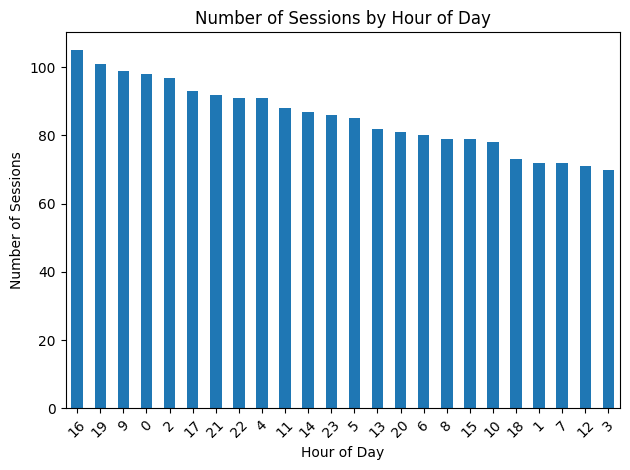

In [24]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
# Create a cursor object
cursor = connection.cursor(dictionary=True)

# Query to fetch popular times of day for playing
query = """
SELECT HOUR(starttime) AS hour_of_day, COUNT(*) AS session_count
FROM sessions
GROUP BY HOUR(starttime)
ORDER BY session_count DESC;
"""

# Execute the query
cursor.execute(query)

# Fetch the results
result = cursor.fetchall()

# Close the cursor
cursor.close()

# Convert the result to a pandas DataFrame
result = pd.DataFrame(result)

# Plotting
plt.figure(figsize=(12, 6))
result.plot(x="hour_of_day", y="session_count", kind="bar", legend=False)
plt.title("Number of Sessions by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Question 3 - Chat Metrics: Calculate the average number of messages per minute sent in each chat room between 8 PM and 9 PM.

We have to populate table with messages

In [4]:
possible_messages = [
    "Hey, everyone! How's everyone doing today?",
    "What games are you all currently playing?",
    "Ready to jump into some gaming action?",
    "How's your day been so far, fellow gamers?",
    "Who's up for some fun gaming sessions?",
    "Anyone here for a chat or a game?",
    "What's your go-to game to unwind after a long day?",
    "Looking to make some new gaming buddies. Who's in?",
    "Who's excited to explore new game worlds?",
    "What's on your gaming agenda for today?",
    "Time for a quick game or just a casual conversation?",
    "Who's online and ready to have a blast?",
    "What's the latest gaming news that caught your attention?",
    "Share your gaming achievements or milestones!",
    "Ready to embark on some epic gaming adventures?",
    "Any game recommendations for today?",
    "Who's in the mood for some multiplayer action?",
    "What's your favorite gaming snack or beverage?",
    "Looking for some gaming company. Join me!",
    "What's the most memorable gaming moment you've had recently?",
    "Calling all adventurers! Join us in our quest to conquer formidable foes and daunting Challenges.",
    "Discussing the art of teamwork when facing Bosses and overcoming game Challenges.",
    "Share your most exhilarating victories and epic fails in Boss battles and Challenges.",
    "Looking to form a formidable squad for taking on the game's toughest trials.",
    "What's your favorite part about tackling challenging Bosses and completing game Challenges?",
    "Ready to strategize and dominate the most challenging aspects of our favorite game.",
    "Let's swap stories about our most memorable encounters with tough game content.",
    "Any tips for newcomers trying to overcome their first Boss or Challenge?",
    "Who enjoys the rush of adrenaline when facing a fierce Boss or nail-biting Challenge?",
    "Discussing the satisfaction of defeating a challenging Boss or completing a difficult Challenge.",
    "Looking for like-minded players who relish the thrill of overcoming game obstacles.",
    "Share your thoughts on the game's difficulty levels and the thrill of conquering them.",
    "Ready to embark on a journey to conquer the game's toughest adversaries and Challenges?",
    "What's your go-to strategy when you find yourself facing a formidable Boss?",
    "Join us for a friendly competition: Who can complete the most Challenges this week?",
    "Discussing the sense of achievement that comes with conquering Bosses and Challenges.",
    "Seeking fellow adventurers to join our party for epic Boss encounters and Challenges.",
    "Share your favorite in-game items or abilities for dealing with Bosses and Challenges.",
    "Who here enjoys theorycrafting and strategizing for upcoming Boss fights and Challenges?",
    "Ready for a night of intense gaming, tackling Bosses and conquering Challenges?",
    "Who's up for tackling a tough Boss or Challenge today? Let's assemble a team!",
    "Discussing strategies to conquer those challenging Bosses and tough game Challenges.",
    "Share your tips for overcoming the most challenging game Bosses.",
    "Looking for advice on how to beat the game's toughest Challenges.",
    "Ready to take on some epic Boss battles or daunting Challenges together?",
    "What's your preferred approach when facing Bosses or tricky game Challenges?",
    "Any memorable victories against Bosses or completing Challenges you'd like to share?",
    "Who here enjoys a good challenge in-game? Let's talk about our experiences.",
    "Share your strategies for staying calm and focused during intense Boss fights.",
    "Looking for fellow gamers to team up and tackle Bosses and Challenges!"
]

chat_room_ids = [1, 4, 5, 6, 10, 11]
user_ids = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 22, 23, 25, 26, 28, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 55, 56, 58, 60, 62, 63, 64, 66, 67, 69, 70, 71, 72, 74, 75, 77, 78, 80, 81, 82, 83, 85, 87, 89, 90, 93, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 109, 110, 112, 113, 114, 116, 119, 120, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 140, 142, 145, 148, 149, 150, 152, 154, 155, 156, 157, 158, 161, 164, 167, 170, 172, 173, 175, 176, 179, 182, 184, 187, 190, 191, 192, 193, 196, 199, 202, 204, 206, 208, 209, 211, 212, 213, 214, 215, 217, 220, 221, 224, 225, 226, 229, 232, 234, 235, 237, 238, 239, 241, 243, 246, 247, 249, 252, 255, 258, 261, 263, 264, 265, 268, 270, 272, 275, 277, 279, 281, 991
]


In [28]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

num_messages = 1000

for _ in range(num_messages):
    # Randomly select chat room ID, user ID, and message from the given lists
    chat_room_id = random.choice(chat_room_ids)
    user_id = random.choice(user_ids)
    message = random.choice(possible_messages)

    # Generate random timestamp between 2021-01-01 and 2023-01-01
    start_date = datetime(2021, 1, 1)
    end_date = datetime(2023, 1, 1)
    random_timestamp = start_date + (end_date - start_date) * random.random()

    # SQL query to insert random data into chatmessages table
    query = """
    INSERT INTO chatmessages (ChatRoomID, UserID, MessageContent, Timestamp)
    VALUES (%s, %s, %s, %s)
    """
    cursor.execute(query, (chat_room_id, user_id, message, random_timestamp))

# Commit changes to the database
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

In [30]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor(dictionary=True)

# Query to fetch average messages per minute for each chat room between 8 PM and 9 PM
query = """
    SELECT 
        ChatRoomID,
        COUNT(MessageID) as total_messages,
        COUNT(MessageID) / 60 as avg_messages_per_minute
    FROM chatmessages
    WHERE HOUR(Timestamp) = 20
    GROUP BY ChatRoomID;
    """

# Execute the query
cursor.execute(query)

# Fetch the results
result = cursor.fetchall()

# Close the cursor
cursor.close()

# Close the connection
connection.close()

result = pd.DataFrame(result)
result

,ChatRoomID,total_messages,avg_messages_per_minute
0,1,6,0.1000
1,4,5,0.0833
2,5,11,0.1833
3,6,7,0.1167
4,10,8,0.1333
5,11,3,0.0500


# Question 4 - Guild Affiliation: Examine the distribution of players in various guilds to find out which guilds are the most popular or exclusive.

In [7]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

sql = """
SELECT 
    pwg.guild_id,
    COUNT(DISTINCT ch.player_id) AS unique_player_count
FROM 
    player_with_guild AS pwg
JOIN 
    characters AS ch ON pwg.character_id = ch.id
GROUP BY 
    pwg.guild_id
ORDER BY 
    unique_player_count DESC;
"""

cursor.execute(sql)

# Fetching and printing the results
result = cursor.fetchall()
result = pd.DataFrame(result, columns=['Guild ID', 'Unique Player Count'])
# Closing the connection
cursor.close()

True

In [8]:
result

,Guild ID,Unique Player Count
0,70,20
1,93,20
2,7,19
3,44,19
4,90,19
...,...,...
164,50,8
165,178,8
166,156,7
167,276,6


# Question 5

In [2]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

sql = """
CREATE TABLE player_with_quest (
    id INT AUTO_INCREMENT PRIMARY KEY,
    character_id INT NOT NULL,
    quest_id INT NOT NULL,
    timestamp DATETIME NOT NULL,
    value ENUM('started', 'completed') NOT NULL,
    FOREIGN KEY (character_id) REFERENCES characters(id),
    FOREIGN KEY (quest_id) REFERENCES quests(QuestID)
);
"""

cursor.execute(sql)

connection.commit()

cursor.close()
connection.close()


In [5]:
# Set a seed for reproducibility
np.random.seed(42)

# Generate random data
num_entries = 5000
character_ids = np.random.choice(user_ids, num_entries)
quest_ids = np.random.randint(1, 11, num_entries)
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 1, 1)
date_range = (end_date - start_date).days
timestamps = [
    start_date + timedelta(
        days=np.random.randint(0, date_range),
        hours=np.random.randint(0, 24),
        minutes=np.random.randint(0, 60),
        seconds=np.random.randint(0, 60)
    ) for _ in range(num_entries)
]
values = ['Started'] * num_entries

# Create DataFrame
quest_events_df = pd.DataFrame({
    'character_id': character_ids,
    'quest_id': quest_ids,
    'timestamp': timestamps,
    'value': values
})

# Drop duplicates based on character_id and quest_id
quest_events_df = quest_events_df.drop_duplicates(subset=['character_id', 'quest_id'])

# Optionally, you can shuffle the rows to make the data more random
quest_events_df = quest_events_df.sample(frac=1).reset_index(drop=True)

In [6]:
# Sample 60% of the original DataFrame
sample_df = quest_events_df.sample(frac=0.7).reset_index(drop=True)

# Add delta to the timestamps
deltas = [
    timedelta(
        days=np.random.randint(0, 30),
        hours=np.random.randint(0, 24),
        minutes=np.random.randint(0, 60),
        seconds=np.random.randint(0, 60)
    ) for _ in range(len(sample_df))
]

sample_df['timestamp'] = sample_df['timestamp'] + pd.Series(deltas)
sample_df['value'] = 'Completed'

# Concatenate the original DataFrame with the new rows
quest_events_df = pd.concat([quest_events_df, sample_df]).reset_index(drop=True)

# Ensure there are no duplicates
quest_events_df = quest_events_df.drop_duplicates(subset=['character_id', 'quest_id', 'value'])

In [7]:
quest_events_df

,character_id,quest_id,timestamp,value
0,232,3,2022-10-13 05:19:34,Started
1,41,5,2022-06-16 17:35:27,Started
2,85,3,2022-05-30 19:40:34,Started
3,220,2,2022-05-19 14:47:48,Started
4,90,8,2022-10-16 14:36:04,Started
...,...,...,...,...
2814,8,7,2022-12-29 11:53:00,Completed
2815,263,2,2021-10-05 14:52:04,Completed
2816,199,5,2021-10-11 11:13:20,Completed
2817,52,6,2022-07-08 13:39:04,Completed


In [8]:
# Populate
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

for _, row in quest_events_df.iterrows():
    sql = """INSERT INTO player_with_quest (character_id, quest_id, timestamp, value) 
             VALUES (%s, %s, %s, %s)"""
    cursor.execute(sql, (row['character_id'], row['quest_id'], row['timestamp'], row['value']))

# Commit the changes
connection.commit()

In [9]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="ElvinSQL",
    database="schema_one"
)
cursor = connection.cursor()

sql = """
SELECT 
    quest_id,
    SUM(CASE WHEN value = 'started' THEN 1 ELSE 0 END) as starts,
    SUM(CASE WHEN value = 'completed' THEN 1 ELSE 0 END) as completions,
    (SUM(CASE WHEN value = 'started' THEN 1 ELSE 0 END) - SUM(CASE WHEN value = 'completed' THEN 1 ELSE 0 END)) as dropout_rate
FROM 
    player_with_quest
GROUP BY 
    quest_id
ORDER BY 
    dropout_rate DESC;
"""

cursor.execute(sql)

# Fetching and printing the results
result = cursor.fetchall()
result = pd.DataFrame(result, columns=['quest_id', 'starts', 'completions', 'dropout_rate'])
# Closing the connection
cursor.close()

True

In [10]:
result

,quest_id,starts,completions,dropout_rate
0,2,171,108,63
1,5,166,111,55
2,6,166,111,55
3,1,167,115,52
4,8,164,115,49
5,4,165,118,47
6,3,164,118,46
7,7,165,120,45
8,10,170,125,45
9,9,160,120,40


# Question 6

In [11]:
connection = mysql.connector.connect(
host="localhost",
user="root",
password="ElvinSQL",
database="schema_one")

cursor = connection.cursor()

sql = """
SELECT 
    quest_id,
    DATE(timestamp) as quest_date,
    COUNT(DISTINCT CASE WHEN value = 'Completed' THEN character_id END) as completions
FROM 
    player_with_quest
WHERE 
    value = 'Completed'
GROUP BY 
    quest_id, quest_date
ORDER BY 
    quest_id, quest_date;
"""

cursor.execute(sql)

# Fetching and printing the results
result = cursor.fetchall()
result = pd.DataFrame(result, columns=['quest_id', 'quest_date', 'completions'])
# Closing the connection
cursor.close()

True

In [13]:
result[result['completions'] >2]

,quest_id,quest_date,completions
234,3,2021-06-12,3
387,4,2022-02-15,3
631,6,2022-12-08,3
895,9,2021-09-02,3


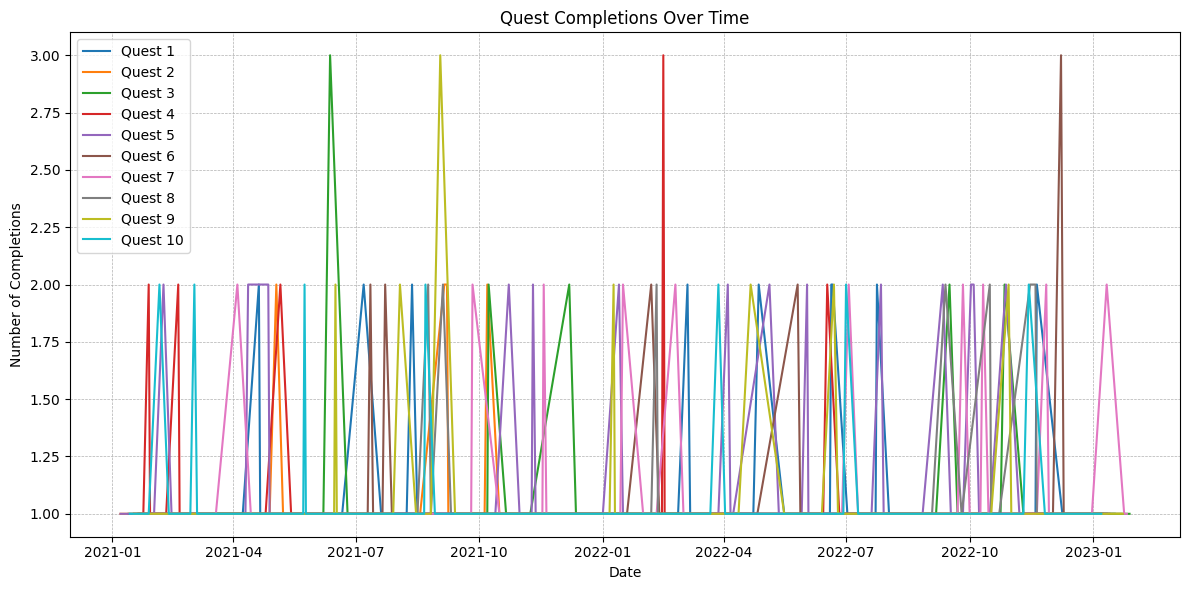

In [17]:
# Convert date from string to datetime format
result['quest_date'] = pd.to_datetime(result['quest_date'])

# Plotting
plt.figure(figsize=(12,6))
for quest, group in result.groupby('quest_id'):
    plt.plot(group['quest_date'], group['completions'], label=f"Quest {quest}")

plt.title("Quest Completions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Completions")
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()